<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [102]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [6]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

--2023-06-02 15:34:46--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2023-06-02 15:34:46--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2023-06-02 15:34:46--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (

In [7]:
# Posibles bandas
os.listdir("./songs_dataset/")

['al-green.txt',
 'joni-mitchell.txt',
 'Lil_Wayne.txt',
 'leonard-cohen.txt',
 'kanye-west.txt',
 'prince.txt',
 'lady-gaga.txt',
 'amy-winehouse.txt',
 'kanye.txt',
 'paul-simon.txt',
 'dj-khaled.txt',
 'janisjoplin.txt',
 'beatles.txt',
 'disney.txt',
 'radiohead.txt',
 'bruce-springsteen.txt',
 'bob-dylan.txt',
 'nursery_rhymes.txt',
 'cake.txt',
 'bruno-mars.txt',
 'r-kelly.txt',
 'notorious-big.txt',
 'nicki-minaj.txt',
 'Kanye_West.txt',
 'nickelback.txt',
 'lorde.txt',
 'nirvana.txt',
 'dickinson.txt',
 'lil-wayne.txt',
 'bieber.txt',
 'notorious_big.txt',
 'lin-manuel-miranda.txt',
 'ludacris.txt',
 'rihanna.txt',
 'missy-elliott.txt',
 'adele.txt',
 'dr-seuss.txt',
 'britney-spears.txt',
 'jimi-hendrix.txt',
 'patti-smith.txt',
 'johnny-cash.txt',
 'bob-marley.txt',
 'dolly-parton.txt',
 'eminem.txt',
 'bjork.txt',
 'alicia-keys.txt',
 'drake.txt',
 'blink-182.txt',
 'michael-jackson.txt']

In [61]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('/content/drive/MyDrive/UBA/NLP/corpus.txt', sep='/n', header=None)
df.head()

<ipython-input-61-6892a35dec9f>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('/content/drive/MyDrive/UBA/NLP/corpus.txt', sep='/n', header=None)


,0
0,Don Damián entró en la inconsciencia rápidamen...
1,Empezaba a clarear. Por los cristales de las v...
2,Hubo un prolongado revuelo de faldas alrededor...
3,"-¡Ay, Dios mío, Dios mío, que no sea tarde! -c..."
4,Pero era tarde. A un mismo tiempo la aguja pen...


In [62]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 516


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [63]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 2

In [64]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

'Don Damián entró en la inconsciencia rápidamente, a compás con la fiebre que iba subiendo por encima de treinta y nueve grados. Su alma se sentía muy incómoda, casi a punto de calcinarse, razón por la cual comenzó a irse recogiendo en el corazón. El alma tenía infinita cantidad de tentáculos, como un pulpo de innúmeros pies, cada uno metido en una vena y algunos sumamente delgados metidos en vasos. Poco a poco fue retirando esos pies, y a medida que iba haciéndolo don Damián perdía calor y empalidecía. Se le enfriaron primero las manos, luego las piernas y los brazos; la cara comenzó a ponerse atrozmente pálida, cosa que observaron las personas que rodeaban el lujoso lecho. La propia enfermera se asustó y dijo que era tiempo de llamar al médico. El alma oyó esas palabras y pensó: “Hay que apresurarse, o viene ese señor y me obliga a quedarme aquí hasta que me queme la fiebre”.'

In [65]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['don',
 'damián',
 'entró',
 'en',
 'la',
 'inconsciencia',
 'rápidamente',
 'a',
 'compás',
 'con',
 'la',
 'fiebre',
 'que',
 'iba',
 'subiendo',
 'por',
 'encima',
 'de',
 'treinta',
 'y',
 'nueve',
 'grados',
 'su',
 'alma',
 'se',
 'sentía',
 'muy',
 'incómoda',
 'casi',
 'a',
 'punto',
 'de',
 'calcinarse',
 'razón',
 'por',
 'la',
 'cual',
 'comenzó',
 'a',
 'irse',
 'recogiendo',
 'en',
 'el',
 'corazón',
 'el',
 'alma',
 'tenía',
 'infinita',
 'cantidad',
 'de',
 'tentáculos',
 'como',
 'un',
 'pulpo',
 'de',
 'innúmeros',
 'pies',
 'cada',
 'uno',
 'metido',
 'en',
 'una',
 'vena',
 'y',
 'algunos',
 'sumamente',
 'delgados',
 'metidos',
 'en',
 'vasos',
 'poco',
 'a',
 'poco',
 'fue',
 'retirando',
 'esos',
 'pies',
 'y',
 'a',
 'medida',
 'que',
 'iba',
 'haciéndolo',
 'don',
 'damián',
 'perdía',
 'calor',
 'y',
 'empalidecía',
 'se',
 'le',
 'enfriaron',
 'primero',
 'las',
 'manos',
 'luego',
 'las',
 'piernas',
 'y',
 'los',
 'brazos',
 'la',
 'cara',
 'comenzó',
 'a',

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [66]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [67]:
# Demos un vistazo
sentence_tokens[:2]

[['don',
  'damián',
  'entró',
  'en',
  'la',
  'inconsciencia',
  'rápidamente',
  'a',
  'compás',
  'con',
  'la',
  'fiebre',
  'que',
  'iba',
  'subiendo',
  'por',
  'encima',
  'de',
  'treinta',
  'y',
  'nueve',
  'grados',
  'su',
  'alma',
  'se',
  'sentía',
  'muy',
  'incómoda',
  'casi',
  'a',
  'punto',
  'de',
  'calcinarse',
  'razón',
  'por',
  'la',
  'cual',
  'comenzó',
  'a',
  'irse',
  'recogiendo',
  'en',
  'el',
  'corazón',
  'el',
  'alma',
  'tenía',
  'infinita',
  'cantidad',
  'de',
  'tentáculos',
  'como',
  'un',
  'pulpo',
  'de',
  'innúmeros',
  'pies',
  'cada',
  'uno',
  'metido',
  'en',
  'una',
  'vena',
  'y',
  'algunos',
  'sumamente',
  'delgados',
  'metidos',
  'en',
  'vasos',
  'poco',
  'a',
  'poco',
  'fue',
  'retirando',
  'esos',
  'pies',
  'y',
  'a',
  'medida',
  'que',
  'iba',
  'haciéndolo',
  'don',
  'damián',
  'perdía',
  'calor',
  'y',
  'empalidecía',
  'se',
  'le',
  'enfriaron',
  'primero',
  'las',
  'm

In [68]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [69]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['don', 'damián'],
 ['damián', 'entró'],
 ['entró', 'en'],
 ['en', 'la'],
 ['la', 'inconsciencia'],
 ['inconsciencia', 'rápidamente'],
 ['rápidamente', 'a'],
 ['a', 'compás'],
 ['compás', 'con'],
 ['con', 'la'],
 ['la', 'fiebre'],
 ['fiebre', 'que'],
 ['que', 'iba'],
 ['iba', 'subiendo'],
 ['subiendo', 'por'],
 ['por', 'encima'],
 ['encima', 'de'],
 ['de', 'treinta'],
 ['treinta', 'y'],
 ['y', 'nueve'],
 ['nueve', 'grados'],
 ['grados', 'su'],
 ['su', 'alma'],
 ['alma', 'se'],
 ['se', 'sentía'],
 ['sentía', 'muy'],
 ['muy', 'incómoda'],
 ['incómoda', 'casi'],
 ['casi', 'a'],
 ['a', 'punto'],
 ['punto', 'de'],
 ['de', 'calcinarse'],
 ['calcinarse', 'razón'],
 ['razón', 'por'],
 ['por', 'la'],
 ['la', 'cual'],
 ['cual', 'comenzó'],
 ['comenzó', 'a'],
 ['a', 'irse'],
 ['irse', 'recogiendo'],
 ['recogiendo', 'en'],
 ['en', 'el'],
 ['el', 'corazón'],
 ['corazón', 'el'],
 ['el', 'alma'],
 ['alma', 'tenía'],
 ['tenía', 'infinita'],
 ['infinita', 'cantidad'],
 ['cantidad', 'de'],
 ['de', 'ten

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [70]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [71]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[18, 11],
 [11, 19],
 [19, 6],
 [6, 4],
 [4, 20],
 [20, 21],
 [21, 2],
 [2, 22],
 [22, 23],
 [23, 4],
 [4, 24],
 [24, 3],
 [3, 12],
 [12, 25],
 [25, 13],
 [13, 26],
 [26, 5],
 [5, 27],
 [27, 1],
 [1, 28],
 [28, 29],
 [29, 30],
 [30, 8],
 [8, 9],
 [9, 31],
 [31, 32],
 [32, 33],
 [33, 34],
 [34, 2],
 [2, 35],
 [35, 5],
 [5, 36],
 [36, 37],
 [37, 13],
 [13, 4],
 [4, 38],
 [38, 14],
 [14, 2],
 [2, 39],
 [39, 40],
 [40, 6],
 [6, 7],
 [7, 41],
 [41, 7],
 [7, 8],
 [8, 42],
 [42, 43],
 [43, 44],
 [44, 5],
 [5, 45],
 [45, 46],
 [46, 47],
 [47, 48],
 [48, 5],
 [5, 49],
 [49, 15],
 [15, 50],
 [50, 51],
 [51, 52],
 [52, 6],
 [6, 53],
 [53, 54],
 [54, 1],
 [1, 55],
 [55, 56],
 [56, 57],
 [57, 58],
 [58, 6],
 [6, 59],
 [59, 16],
 [16, 2],
 [2, 16],
 [16, 60],
 [60, 61],
 [61, 62],
 [62, 15],
 [15, 1],
 [1, 2],
 [2, 63],
 [63, 3],
 [3, 12],
 [12, 64],
 [64, 18],
 [18, 11],
 [11, 65],
 [65, 66],
 [66, 1],
 [1, 67],
 [67, 9],
 [9, 68],
 [68, 69],
 [69, 70],
 [70, 10],
 [10, 71],
 [71, 72],
 [72, 10],


In [72]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

156


In [73]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

109


In [74]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'y': 1, 'a': 2, 'que': 3, 'la': 4, 'de': 5, 'en': 6, 'el': 7, 'alma': 8, 'se': 9, 'las': 10, 'damián': 11, 'iba': 12, 'por': 13, 'comenzó': 14, 'pies': 15, 'poco': 16, 'me': 17, 'don': 18, 'entró': 19, 'inconsciencia': 20, 'rápidamente': 21, 'compás': 22, 'con': 23, 'fiebre': 24, 'subiendo': 25, 'encima': 26, 'treinta': 27, 'nueve': 28, 'grados': 29, 'su': 30, 'sentía': 31, 'muy': 32, 'incómoda': 33, 'casi': 34, 'punto': 35, 'calcinarse': 36, 'razón': 37, 'cual': 38, 'irse': 39, 'recogiendo': 40, 'corazón': 41, 'tenía': 42, 'infinita': 43, 'cantidad': 44, 'tentáculos': 45, 'como': 46, 'un': 47, 'pulpo': 48, 'innúmeros': 49, 'cada': 50, 'uno': 51, 'metido': 52, 'una': 53, 'vena': 54, 'algunos': 55, 'sumamente': 56, 'delgados': 57, 'metidos': 58, 'vasos': 59, 'fue': 60, 'retirando': 61, 'esos': 62, 'medida': 63, 'haciéndolo': 64, 'perdía': 65, 'calor': 66, 'empalidecía': 67, 'le': 68, 'enfriaron': 69, 'primero': 70, 'manos': 71, 'luego': 72, 'piernas': 73, 'los': 74, 'brazos': 75, 'cara

In [75]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'don': 3, 'damián': 4, 'entró': 2, 'en': 8, 'la': 11, 'inconsciencia': 2, 'rápidamente': 2, 'a': 14, 'compás': 2, 'con': 2, 'fiebre': 2, 'que': 14, 'iba': 4, 'subiendo': 2, 'por': 4, 'encima': 2, 'de': 10, 'treinta': 2, 'y': 16, 'nueve': 2, 'grados': 2, 'su': 2, 'alma': 6, 'se': 6, 'sentía': 2, 'muy': 2, 'incómoda': 2, 'casi': 2, 'punto': 2, 'calcinarse': 2, 'razón': 2, 'cual': 2, 'comenzó': 4, 'irse': 2, 'recogiendo': 2, 'el': 8, 'corazón': 2, 'tenía': 2, 'infinita': 2, 'cantidad': 2, 'tentáculos': 2, 'como': 2, 'un': 2, 'pulpo': 2, 'innúmeros': 2, 'pies': 4, 'cada': 2, 'uno': 2, 'metido': 2, 'una': 2, 'vena': 2, 'algunos': 2, 'sumamente': 2, 'delgados': 2, 'metidos': 2, 'vasos': 2, 'poco': 4, 'fue': 2, 'retirando': 2, 'esos': 2, 'medida': 2, 'haciéndolo': 2, 'perdía': 2, 'calor': 2, 'empalidecía': 2, 'le': 2, 'enfriaron': 2, 'primero': 2, 'las': 6, 'manos': 2, 'luego': 2, 'piernas': 2, 'los': 2, 'brazos': 2, 'cara': 2, 'ponerse': 2, 'atrozmente': 2, 'pálid

### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [76]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     Don Damián entró en la inconsciencia rápidamen...
1     Empezaba a clarear. Por los cristales de las v...
2     Hubo un prolongado revuelo de faldas alrededor...
3     -¡Ay, Dios mío, Dios mío, que no sea tarde! -c...
4     Pero era tarde. A un mismo tiempo la aguja pen...
5     -No vayas a comportarte ahora como una desverg...
6          -Cuando llegue gente, mamá -susurró la hija.
7     -No, desde ahora. Acuérdate que la enfermera p...
8     En el acto la flamante viuda corrió hacia la c...
9     -¡Damián, Damián mío; ay, mi Damián! ¿Cómo pod...
10    Otra alma con menos mundo se hubiera asombrado...
11    -¡No puedes prohibirme que le hable! ¡Tú sabes...
12    A lo que don Damián había contestado que con e...
13    Estaba el alma allá arriba, en la lámpara, rec...
14    -Vine porque tenía el presentimiento; vine por...
15    A lo que la suegra del difunto, llena de desco...
Name: 0, dtype: object

In [77]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'Don Damián entró en la inconsciencia rápidamente, a compás con la fiebre que iba subiendo por encima de treinta y nueve grados. Su alma se sentía muy incómoda, casi a punto de calcinarse, razón por la cual comenzó a irse recogiendo en el corazón. El alma tenía infinita cantidad de tentáculos, como un pulpo de innúmeros pies, cada uno metido en una vena y algunos sumamente delgados metidos en vasos. Poco a poco fue retirando esos pies, y a medida que iba haciéndolo don Damián perdía calor y empalidecía. Se le enfriaron primero las manos, luego las piernas y los brazos; la cara comenzó a ponerse atrozmente pálida, cosa que observaron las personas que rodeaban el lujoso lecho. La propia enfermera se asustó y dijo que era tiempo de llamar al médico. El alma oyó esas palabras y pensó: “Hay que apresurarse, o viene ese señor y me obliga a quedarme aquí hasta que me queme la fiebre”. Empezaba a clarear. Por los cristales de las ventanas entraba una luz lívida, que anunciaba el próximo nacimi

In [78]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['don',
 'damián',
 'entró',
 'en',
 'la',
 'inconsciencia',
 'rápidamente',
 'a',
 'compás',
 'con',
 'la',
 'fiebre',
 'que',
 'iba',
 'subiendo',
 'por',
 'encima',
 'de',
 'treinta',
 'y']

In [79]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 19827


In [80]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [81]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['don', 'damián'],
 ['damián', 'entró'],
 ['entró', 'en'],
 ['en', 'la'],
 ['la', 'inconsciencia'],
 ['inconsciencia', 'rápidamente'],
 ['rápidamente', 'a'],
 ['a', 'compás'],
 ['compás', 'con'],
 ['con', 'la'],
 ['la', 'fiebre'],
 ['fiebre', 'que'],
 ['que', 'iba'],
 ['iba', 'subiendo'],
 ['subiendo', 'por'],
 ['por', 'encima'],
 ['encima', 'de'],
 ['de', 'treinta'],
 ['treinta', 'y'],
 ['y', 'nueve']]

In [82]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[23, 26],
 [26, 157],
 [157, 7],
 [7, 2],
 [2, 1053],
 [1053, 585],
 [585, 6],
 [6, 1054],
 [1054, 12],
 [12, 2],
 [2, 213],
 [213, 5],
 [5, 46],
 [46, 469],
 [469, 16],
 [16, 345],
 [345, 1],
 [1, 1055],
 [1055, 4],
 [4, 395]]

In [83]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 19825


### 3 - Input y target

In [84]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [85]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [86]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [87]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(19825, 1)
(19825,)


In [88]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'el',
 4: 'y',
 5: 'que',
 6: 'a',
 7: 'en',
 8: 'se',
 9: 'no',
 10: 'los',
 11: 'un',
 12: 'con',
 13: 'las',
 14: 'su',
 15: 'una',
 16: 'por',
 17: 'había',
 18: 'al',
 19: 'le',
 20: 'del',
 21: 'lo',
 22: 'era',
 23: 'don',
 24: 'para',
 25: 'como',
 26: 'damián',
 27: 'alma',
 28: 'pero',
 29: 'sin',
 30: 'más',
 31: 'estaba',
 32: 'tenía',
 33: 'ella',
 34: 'cuando',
 35: 'él',
 36: 'o',
 37: 'ojos',
 38: 'sobre',
 39: 'me',
 40: 'hacia',
 41: 'todo',
 42: 'agua',
 43: 'si',
 44: 'sus',
 45: 'ya',
 46: 'iba',
 47: 'voz',
 48: 'dijo',
 49: 'pie',
 50: 'qué',
 51: 'dos',
 52: 'ese',
 53: 'tiempo',
 54: 'mujer',
 55: 'hombre',
 56: 'muy',
 57: 'después',
 58: 'remigia',
 59: 'vez',
 60: 'día',
 61: 'porque',
 62: 'allí',
 63: 'cabeza',
 64: 'fue',
 65: 'donde',
 66: 'tan',
 67: 'podía',
 68: 'médico',
 69: 'hasta',
 70: 'sabía',
 71: 'ver',
 72: 'yo',
 73: 'noche',
 74: 'niño',
 75: 'luis',
 76: 'eso',
 77: 'ni',
 78: 'veía',
 79: 'mi',
 80: 'camino',
 81: 

In [89]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3693

In [40]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: ignored

In [90]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [91]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(19825, 3693)

### 4 - Entrenar el modelo

In [92]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

1

In [93]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

3693

In [103]:

# Definir el modelo
model = Sequential()

# Embedding:
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

# Capa LSTM bidireccional
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.1))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(64)))
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
model.add(Dense(vocab_size, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 1, 5)              18470     
                                                                 
 bidirectional_12 (Bidirecti  (None, 1, 128)           35840     
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 1, 256)           263168    
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 1, 256)            0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 128)             

In [104]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
496/496 [==============================] - 22s 22ms/step - loss: 6.7922 - accuracy: 0.0421 - val_loss: 6.9714 - val_accuracy: 0.0371
Epoch 2/50
496/496 [==============================] - 8s 17ms/step - loss: 6.2853 - accuracy: 0.0443 - val_loss: 7.2697 - val_accuracy: 0.0371
Epoch 3/50
496/496 [==============================] - 7s 14ms/step - loss: 6.1944 - accuracy: 0.0458 - val_loss: 7.4961 - val_accuracy: 0.0371
Epoch 4/50
496/496 [==============================] - 8s 16ms/step - loss: 6.1493 - accuracy: 0.0451 - val_loss: 7.5945 - val_accuracy: 0.0441
Epoch 5/50
496/496 [==============================] - 7s 14ms/step - loss: 6.0912 - accuracy: 0.0471 - val_loss: 7.9590 - val_accuracy: 0.0353
Epoch 6/50
496/496 [==============================] - 8s 16ms/step - loss: 5.9616 - accuracy: 0.0581 - val_loss: 7.8942 - val_accuracy: 0.0472
Epoch 7/50
496/496 [==============================] - 8s 15ms/step - loss: 5.8645 - accuracy: 0.0638 - val_loss: 7.8730 - val_accuracy: 0.043

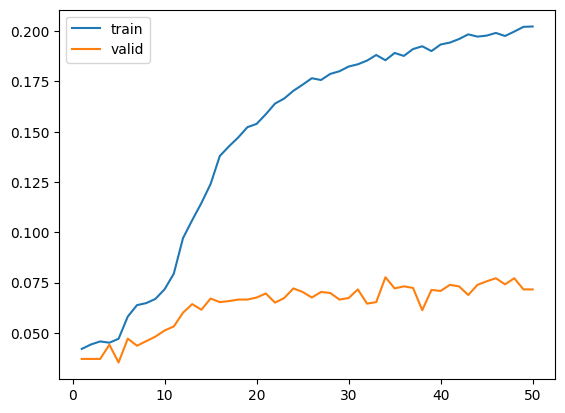

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [107]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [108]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [109]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-109-2a8fe09160a6>:24: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 38ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [110]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

# Explicación del dataset utilizado

Se utiliza un solo txt cargado con 8 cuentos de Juan Bosch obternidos de https://github.com/karen-pal/borges/blob/master/datasets/links/links_bosch.txt 

#conclusión
- No se logra reducor el overfitting con respecto a la clase, sin embargo su razón de crecimiento fue mucho menor al disminuir el largo de la secuencia.
- Se agregaron más capas direccionales lo que también ayudo a reducir esa razón de cambio de overfitting, sin embargo no se eliminó
- Para testear se utilizan ciclos con una frase inicial de solo dos palabras, ejecuta un ciclo for donde las dos palabras predichas ahora hacen parte del siguiente input para predecir.



In [118]:
ini_word='La gente'
for i in range(10):
  if i == 0:  
    input_text = ini_word
  else:
    input_text = generate_seq(model, tok, input_text, max_length=3, n_words=2)
    print(input_text)

1/1 [==============================] - 0s 22ms/step
La gente y era
1/1 [==============================] - 0s 20ms/step
La gente y era se en
1/1 [==============================] - 0s 24ms/step
La gente y era se en de de
1/1 [==============================] - 0s 22ms/step
La gente y era se en de de las damián
1/1 [==============================] - 0s 21ms/step
La gente y era se en de de las damián espinosos causa
1/1 [==============================] - 0s 22ms/step
La gente y era se en de de las damián espinosos causa había don
1/1 [==============================] - 0s 19ms/step
La gente y era se en de de las damián espinosos causa había don alma pero
1/1 [==============================] - 0s 21ms/step
La gente y era se en de de las damián espinosos causa había don alma pero ella el
1/1 [==============================] - 0s 21ms/step
La gente y era se en de de las damián espinosos causa había don alma pero ella el de en


In [120]:
ini_word='asombro suyo'
for i in range(10):
  if i == 0:  
    input_text = ini_word
  else:
    input_text = generate_seq(model, tok, input_text, max_length=3, n_words=2)
    print(input_text)

1/1 [==============================] - 0s 21ms/step
asombro suyo la vieja
1/1 [==============================] - 0s 22ms/step
asombro suyo la vieja duda servidora
1/1 [==============================] - 0s 23ms/step
asombro suyo la vieja duda servidora no de
1/1 [==============================] - 0s 22ms/step
asombro suyo la vieja duda servidora no de con de
1/1 [==============================] - 0s 24ms/step
asombro suyo la vieja duda servidora no de con de de de
1/1 [==============================] - 0s 21ms/step
asombro suyo la vieja duda servidora no de con de de de de de
1/1 [==============================] - 0s 21ms/step
asombro suyo la vieja duda servidora no de con de de de de de de de
1/1 [==============================] - 0s 21ms/step
asombro suyo la vieja duda servidora no de con de de de de de de de de de
1/1 [==============================] - 0s 22ms/step
asombro suyo la vieja duda servidora no de con de de de de de de de de de de de


In [121]:
ini_word='no puede ser'
for i in range(10):
  if i == 0:  
    input_text = ini_word
  else:
    input_text = generate_seq(model, tok, input_text, max_length=3, n_words=2)
    print(input_text)

1/1 [==============================] - 0s 31ms/step
no puede ser la por
1/1 [==============================] - 0s 35ms/step
no puede ser la por de los
1/1 [==============================] - 0s 35ms/step
no puede ser la por de los encima la
1/1 [==============================] - 0s 31ms/step
no puede ser la por de los encima la hacia de
1/1 [==============================] - 0s 44ms/step
no puede ser la por de los encima la hacia de los ese
1/1 [==============================] - 0s 35ms/step
no puede ser la por de los encima la hacia de los ese todo vez
1/1 [==============================] - 0s 36ms/step
no puede ser la por de los encima la hacia de los ese todo vez en 
1/1 [==============================] - 0s 22ms/step
no puede ser la por de los encima la hacia de los ese todo vez en   
1/1 [==============================] - 0s 21ms/step
no puede ser la por de los encima la hacia de los ese todo vez en     


In [122]:
ini_word='can u predict this? '
for i in range(10):
  if i == 0:  
    input_text = ini_word
  else:
    input_text = generate_seq(model, tok, input_text, max_length=3, n_words=2)
    print(input_text)

1/1 [==============================] - 0s 24ms/step
can u predict this?  se en
1/1 [==============================] - 0s 22ms/step
can u predict this?  se en de de
1/1 [==============================] - 0s 23ms/step
can u predict this?  se en de de las damián
1/1 [==============================] - 0s 25ms/step
can u predict this?  se en de de las damián espinosos causa
1/1 [==============================] - 0s 25ms/step
can u predict this?  se en de de las damián espinosos causa había don
1/1 [==============================] - 0s 24ms/step
can u predict this?  se en de de las damián espinosos causa había don alma pero
1/1 [==============================] - 0s 20ms/step
can u predict this?  se en de de las damián espinosos causa había don alma pero ella el
1/1 [==============================] - 0s 21ms/step
can u predict this?  se en de de las damián espinosos causa había don alma pero ella el de en
1/1 [==============================] - 0s 27ms/step
can u predict this?  se en de de las

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.